In [21]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [22]:
!pip install tensorflow opencv-contrib-python youtube-dl moviepy pydot
!pip install git+https://github.com/TahaAnwar/pafy.git#egg=pafy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/TahaAnwar/pafy.git to /tmp/pip-install-epby5dt7/pafy_af67e62e099b43a9b7b13d5a467467c4
  Running command git clone -q https://github.com/TahaAnwar/pafy.git /tmp/pip-install-epby5dt7/pafy_af67e62e099b43a9b7b13d5a467467c4


In [ ]:
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2613248/45929032 bytes (5.7%)5980160/45929032 bytes (13.0%)9437184/45929032 bytes (20.5%)12845056/45929032 bytes (28.0%)16211968/45929032 bytes (35.3%)19685376/45929032 bytes (42.9%)22765568/45929032 bytes (49.6%)25542656/45929032 bytes (55.6%)28573696/45929032 bytes (62.2%)32038912/45929032 bytes (69.8%)35037184/45929032 bytes (76.3%)38109184/45929032 bytes (83.0%)

In [23]:
os.chdir('/content/drive/MyDrive/UCF_try/dataset')
os.listdir()

['BlowingCandles',
 'BodyWeightSquats',
 'BoxingPunchingBag',
 'Bowling',
 'convlstm_model_structure_plot.png',
 'model.png',
 'convlstm_model___Date_Time_2022_05_14__18_46_27___Loss_0.584220290184021___Accuracy_0.8148148059844971.h5']

In [24]:
SEQUENCE_LENGTH = 20
IMAGE_HEIGHT , IMAGE_WIDTH=64,64
DATASET_DIR="/content/drive/MyDrive/UCF_try/dataset"
CLASS_LIST=["BlowingCandles", 'BodyWeightSquats', 'BoxingPunchingBag', 'Bowling']
class_name_list=os.listdir('/content/drive/MyDrive/UCF_try/dataset')


In [25]:
class_name_list

['BlowingCandles',
 'BodyWeightSquats',
 'BoxingPunchingBag',
 'Bowling',
 'convlstm_model_structure_plot.png',
 'model.png',
 'convlstm_model___Date_Time_2022_05_14__18_46_27___Loss_0.584220290184021___Accuracy_0.8148148059844971.h5']

In [26]:

def frames_extraction(video_path):
  frames_list=[]
  cap=cv2.VideoCapture(video_path)
  video_frames_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) #total frame count
  skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1) 
  for i in range(SEQUENCE_LENGTH):
    cap.set(cv2.CAP_PROP_POS_FRAMES, i* skip_frames_window) 
    # SET POSITION OF CURRENT FRAME
    ret,frame=cap.read()
    if not ret:
      break
    frame=cv2.cvtColor(frame , cv2.COLOR_BGR2GRAY)
    resized_frame = cv2.resize(frame/255.0, (IMAGE_HEIGHT, IMAGE_WIDTH)) 
    frames_list.append(resized_frame)
  cap.release()
  return frames_list


In [27]:
def create_dataset():
    features = []
    labels = []
    for class_index, class_name in enumerate(CLASS_LIST):
      files_list=os.listdir(os.path.join(DATASET_DIR , class_name))
      for videos in files_list:
        video_path=os.path.join(DATASET_DIR ,class_name , videos )
        frames = frames_extraction(video_path)
        if len(frames) == SEQUENCE_LENGTH:
          features.append(frames)
          labels.append(class_index)
    features = np.asarray(features)
    labels = np.array(labels)  
    return features, labels
          

In [28]:
features, labels= create_dataset()

In [ ]:
features[0].shape

(20, 64, 64)

In [ ]:
one_hot_encoded_labels = to_categorical(labels)

In [ ]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            random_state = 2)

In [ ]:
features_train.shape

(404, 20, 64, 64)

In [ ]:
def convlstm_model():
  
    model = Sequential()
    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 1)))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(Flatten()) 
    
    model.add(Dense(len(CLASS_LIST), activation = "softmax"))
    
    ########################################################################################################################
     
    # Display the models summary.
    model.summary()
    
    # Return the constructed convlstm model.
    return model

In [ ]:
convlstm_model1 = convlstm_model()

# Display the success message. 

print("Model Created Successfully!")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_4 (ConvLSTM2D)  (None, 20, 62, 62, 4)     736       
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 20, 31, 31, 4)    0         
 3D)                                                             
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 31, 31, 4)    0         
 tributed)                                                       
                                                                 
 conv_lstm2d_5 (ConvLSTM2D)  (None, 20, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_5 (MaxPooling  (None, 20, 15, 15, 8)    0         
 3D)                                                             
                                                      

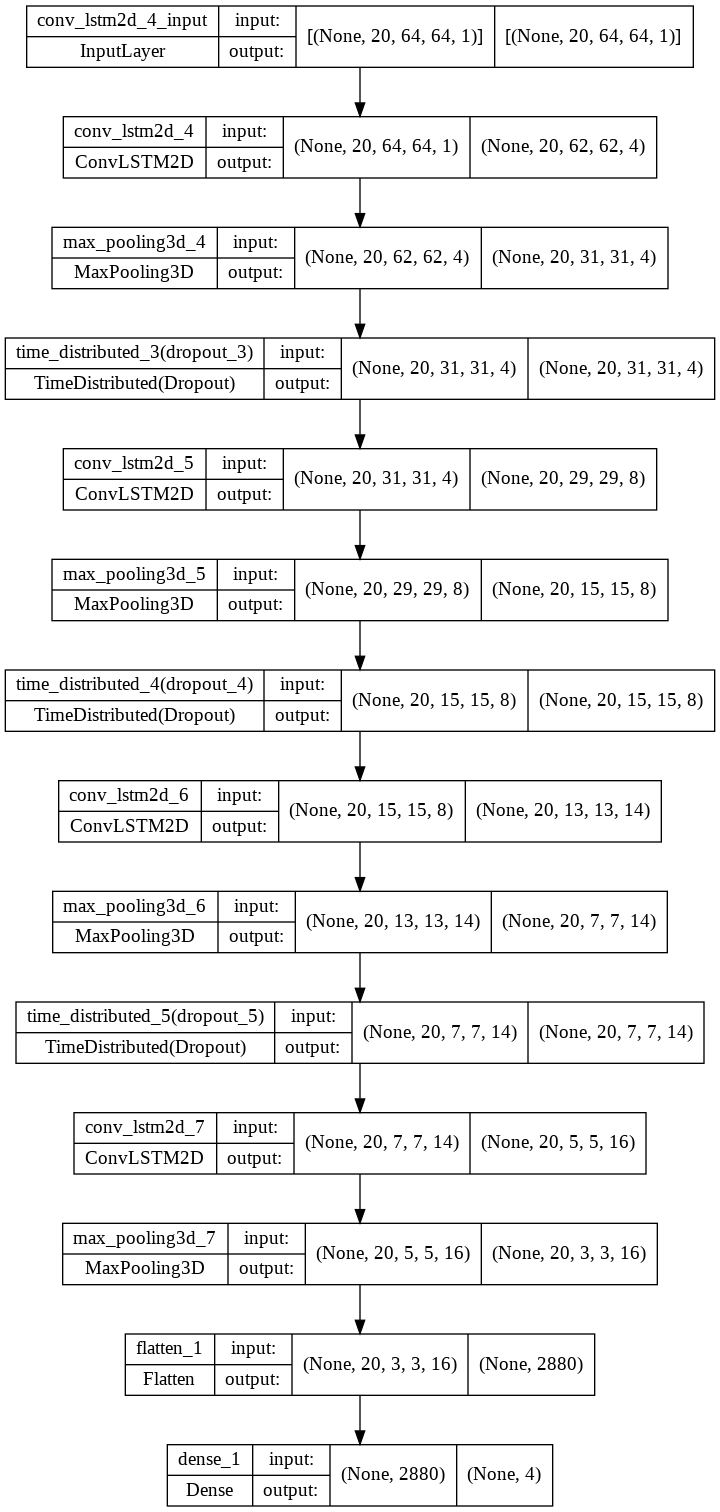

In [ ]:
convlstm_model1.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

plot_model(convlstm_model1, show_shapes = True, show_layer_names = True)

In [ ]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model
convlstm_model1.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
convlstm_model_training_history = convlstm_model1.fit(x = features_train, y = labels_train, epochs = 20, batch_size = 4,
                                                     shuffle = True, validation_split = 0.2, 
                                                     callbacks = [early_stopping_callback])

Epoch 1/20
81/81 [==============================] - 176s 2s/step - loss: 1.3492 - accuracy: 0.3715 - val_loss: 1.1768 - val_accuracy: 0.6049
Epoch 2/20
81/81 [==============================] - 159s 2s/step - loss: 1.1477 - accuracy: 0.5046 - val_loss: 0.9780 - val_accuracy: 0.6420
Epoch 3/20
81/81 [==============================] - 158s 2s/step - loss: 1.0025 - accuracy: 0.6099 - val_loss: 0.7637 - val_accuracy: 0.6914
Epoch 4/20
81/81 [==============================] - 159s 2s/step - loss: 0.7700 - accuracy: 0.7090 - val_loss: 0.6352 - val_accuracy: 0.7901
Epoch 5/20
81/81 [==============================] - 154s 2s/step - loss: 0.5737 - accuracy: 0.7585 - val_loss: 0.5849 - val_accuracy: 0.7778
Epoch 6/20
81/81 [==============================] - 156s 2s/step - loss: 0.3777 - accuracy: 0.8545 - val_loss: 0.5961 - val_accuracy: 0.7531
Epoch 7/20
81/81 [==============================] - 153s 2s/step - loss: 0.2903 - accuracy: 0.8978 - val_loss: 0.4087 - val_accuracy: 0.8395
Epoch 8/20
81

In [29]:
predicted=convlstm_model1.predict(features_test)

In [30]:
model_evaluation_history = convlstm_model1.evaluate(features_test, labels_test)

5/5 [==============================] - 16s 3s/step - loss: 0.5153 - accuracy: 0.8889


In [52]:
convlstm_model1.save('/content/drive/MyDrive/UCF_try/LSTM_VIDclassi')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/UCF_try/LSTM_VIDclassi/assets


In [31]:
model_evaluation_loss , model_evaluation_accuracy=model_evaluation_history


In [32]:
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save your Model.
convlstm_model1.save(model_file_name)

In [33]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    epochs = range(len(metric_value_1))
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)
    plt.title(str(plot_name))
    plt.legend()

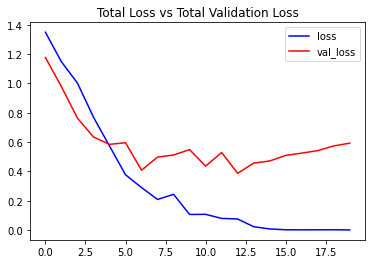

In [34]:
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

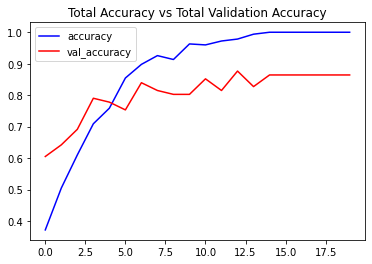

In [35]:
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy') 

In [53]:
model_evaluation_history = convlstm_model1.evaluate(features_test, labels_test)

5/5 [==============================] - 17s 3s/step - loss: 0.5153 - accuracy: 0.8889
